# Analyze the loss based on the simulations runtime

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [2]:
import jax.numpy as jnp
import jax

import numpy as onp

import matplotlib.pyplot as plt

from simulation.simulate_full import run_entire_simulation

from analyzers import defaultvalues as dv, database, loss as loss_anaylzer

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
scan_space = jnp.linspace(3.0000, 3.0001, 8)
nmolecules_values = onp.array([3, 4, 5, 6, 7, 8, 9])

In [4]:
def get_sim_result(lj_sigma_oo, n_molecules):
    return run_entire_simulation(lj_sigma_oo, dv.N_STEPS, n_molecules, dv.N_SNAPSHOTS, dv.N_Q, 1)

In [3]:
database.set_filename("../data/loss_analyzer/nmolecules_scan.npz")

Calculate losses over the scan space for each runtime from the array

In [6]:
all_losses = []

for n_molecules in nmolecules_values:
    existing_keys = database.get_existing_keys()
    if n_molecules in existing_keys:
        print(f"Skipping {n_molecules}, was already computed")
        continue

    print(f"=== Running for {n_molecules}^3 = {n_molecules**3} molecules ===")
    reference = get_sim_result(dv.LJ_SIGMA_OO, n_molecules)
    losses = jax.vmap(lambda lj_sigma_oo: loss_anaylzer.L1_loss(get_sim_result(lj_sigma_oo, n_molecules), reference))(scan_space)
            
    jitter = loss_anaylzer.get_loss_jitter(losses)
    print(f"Jitter: {jitter}")

    database.save_intermediate_result(n_molecules, losses)

Skipping 3, was already computed
Skipping 4, was already computed
Skipping 5, was already computed
Skipping 6, was already computed
Skipping 7, was already computed
Skipping 8, was already computed
Skipping 9, was already computed


# Plot
Skip previous if data is already available

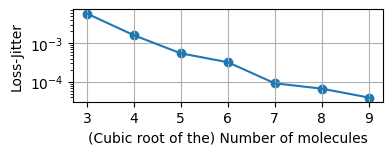

In [8]:
keys, values = database.load_result()
jitter_values = [loss_anaylzer.get_loss_jitter(v) for v in values]

plt.plot(keys, jitter_values)
plt.scatter(keys, jitter_values)
plt.xlabel("(Cubic root of the) Number of molecules")
plt.ylabel("Loss-Jitter")
plt.yscale("log")

plt.grid()
plt.gcf().set_size_inches(4, 1.2)
plt.savefig("../plots/analysis_loss_nmolecules.svg")
plt.show()